In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
if "classification" in os.path.abspath(os.path.curdir): os.chdir("..")
BASE_DIR = os.path.abspath(os.path.curdir)
DATASET_DIR = os.path.join(BASE_DIR, "datasets", "classifications", "flowers")

## Data Preprocessing
    - Images come from different sources and shapes.
    - so first need to make them into same size

In [5]:
from PIL import Image, ImageOps
image_path = os.path.join(BASE_DIR, "datasets", "classifications", "flowers", "daisy", "5547758_eea9edfd54_n.jpg")
rgb_image = Image.open(image_path)
rgb_array = np.array(rgb_image)

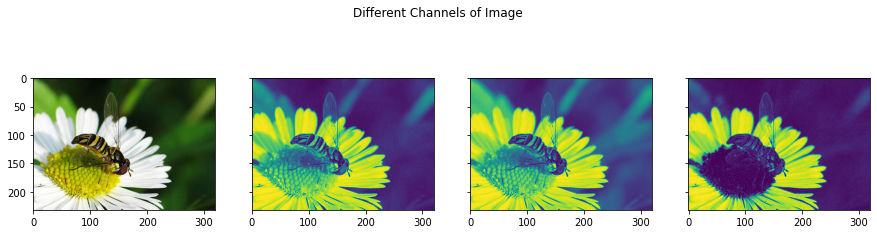

In [8]:
# plotting the original image and the RGB channels
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
f.set_figwidth(15)
ax1.imshow(rgb_array)

# RGB channels
# CHANNELID : 0 for Red, 1 for Green, 2 for Blue. 
ax2.imshow(rgb_array[:, : , 0]) #Red
ax3.imshow(rgb_array[:, : , 1]) #Green
ax4.imshow(rgb_array[:, : , 2]) #Blue
f.suptitle('Different Channels of Image')
plt.show()

# ref: https://towardsdatascience.com/data-preprocessing-and-network-building-in-cnn-15624ef3a28b

### Morphological Transformation
    - The term morphological transformation refers to any modification involving the shape and form of the images.
    -Although they are used with all types of images, they are especially powerful for images that are not natural (come from a source other than a picture of the real world). 
    - The typical transformations are erosion, dilation, opening, and closing. 
    
    ref: https://towardsdatascience.com/data-preprocessing-and-network-building-in-cnn-15624ef3a28b

#### Thresholding
    - One of the simpler operations where we take all the pixels whose intensities are above a certain threshold and convert them to ones; the pixels having value less than the threshold are converted to zero. This results in a binary image.

In [ ]:
gray_image = ImageOps.grayscale(rgb_image)

In [ ]:
arr_image = np.array(gray_image)

In [ ]:
arr_image = arr_image.reshape((1,arr_image.shape[0]*arr_image.shape[1]))
# arr_image = np.append(arr_image, ["daisy"])

In [ ]:
arrs = np.append(arr_image, np.array(gray_image).reshape((1,arr_image.shape[0]*arr_image.shape[1])), axis=0)

In [ ]:
pd.DataFrame(arrs)

In [ ]:
type(arr_image)

In [ ]:
class LoadData:
    def __init__(self):
        self.array = None
        self.dir_list = os.listdir(DATASET_DIR)
        
    def load_and_prepare_data(self):
        for i, dir_ in enumerate(self.dir_list):
            if i > 0: continue
            dir_path = os.path.join(DATASET_DIR, dir_)
            for j, img_file in enumerate(os.listdir(dir_path)):
                rgb_image = Image.open(os.path.join(DATASET_DIR, dir_, img_file))
                gray_image = ImageOps.grayscale(rgb_image)
                arr_image = np.array(gray_image)
                arr_image = np.array(gray_image).reshape((1, arr_image.shape[0]*arr_image.shape[1]))
                if not isinstance(self.array, np.ndarray):
                    self.array = arr_image
                else:
                    np.append(self.array, arr_image, axis=0)

In [ ]:
ld = LoadData()
ld.load_and_prepare_data()